<a href="https://colab.research.google.com/github/danchaud-vincent/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06 - Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

In the previous two notebooks (**transfer learning part 1: feature extraction** and **part 2: fine-tuning**) we've seen the power of transfer learning.

Now we know our smaller modelling experiments are working, it's time to step things up a notch with more data.

This is a common practice in machine learning and deep learning: get a model working on a small amount of data before scaling it up to a larger amount of data.

It's time to get closer to our Food Vision project coming to life. In this notebook we're going to scale up from  using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

Our goal is to **beat the original Food101 paper's results with 10% of data**.

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/06-ml-serial-experimentation.png)
***Machine learning practitioners are serial experimenters. Start small, get a model working, see if yout experiments work then gradually scale them up to where you want to go (we're going to be looking at scaling up throughout this notebook).*

## What we're going to cover

We're going to go through the follow with TensorFlow:
- Downloading and preparing 10% of the Food101 data (10% of training data).
- Training a feature extraction transfer learning model on 10% of the Food101 training data.
- Fine-tuning our feature extraction model.
- Saving and loaded our trained model.
- Evaluating the performance of our Food Vision model trained on 10% of the training data
  - Finding our model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food.

In [14]:
# Are we using a GPU?
!nvidia-smi

Tue Oct 18 17:56:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W /  70W |    342MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating Helper Functions


We've created a series of helper functions throughout the previous notebooks. Instead of rewriting them (tedious), we'll import the `helper_functions.py` file from the Github repo.


In [15]:
# Get helper functions file
!wget https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/utils/helper_functions.py

--2022-10-18 17:56:53--  https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4405 (4.3K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]   4.30K  --.-KB/s    in 0s      

2022-10-18 17:56:53 (49.1 MB/s) - ‘helper_functions.py.1’ saved [4405/4405]



In [16]:
# Import series of helper function for the notebook
from helper_functions import plot_loss_curves, unzip_data, compare_historys, walk_through_dir, create_tensorboard_callback

## 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original Food101 dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 images.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

## Downloading and preprocessing the data

Just as before we'll download a subset of the Food101 dataset which has been extracted from the original dataset (to see the preprocessing of the data check out the [ Food Vision preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

We download the data as a zip file so we'll use our unzip_data() function to unzip it.

In [17]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2022-10-18 17:56:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.132.128, 74.125.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  79.6MB/s    in 11s     

2022-10-18 17:57:05 (137 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [18]:
# unzip the data
unzip_data("101_food_classes_10_percent.zip")

In [19]:
# train and test directories
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [20]:
# Walk through our dir
walk_through_dir("101_food_classes_10_percent")

101_food_classes_10_percent: There are 2 directories and 0 files
101_food_classes_10_percent/train: There are 101 directories and 0 files
101_food_classes_10_percent/train/gyoza: There are 0 directories and 75 files
101_food_classes_10_percent/train/cup_cakes: There are 0 directories and 75 files
101_food_classes_10_percent/train/sashimi: There are 0 directories and 75 files
101_food_classes_10_percent/train/waffles: There are 0 directories and 75 files
101_food_classes_10_percent/train/french_toast: There are 0 directories and 75 files
101_food_classes_10_percent/train/pho: There are 0 directories and 75 files
101_food_classes_10_percent/train/hot_and_sour_soup: There are 0 directories and 75 files
101_food_classes_10_percent/train/ramen: There are 0 directories and 75 files
101_food_classes_10_percent/train/hot_dog: There are 0 directories and 75 files
101_food_classes_10_percent/train/baby_back_ribs: There are 0 directories and 75 files
101_food_classes_10_percent/train/bruschetta: 

Let's use the `image_dataset_from_directory()` function to turn our images and labels into a `tf.data.Dataset`, a TensorFlow datatype which allows for us to pass it directory to our model.

For the test dataset, we're going to set `shuffle=False` so we can perform repeatable evaluation and visualization on it later.

In [21]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Our food image data has been imported into TensorFlow, time to model it.

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beeat the baseline from original **Food101 paper** (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:

- A `ModelCheckpoint` callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time.
- Data augmentation built right into the model
- A headless (no top layers) `EfficientNetB0` architecture from `
tf.keras.applications` as our base model.
- A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer.
- Categorical crossentropy as the loss function since we're dealing with more than two classes.
- The Adam optimizer with the default settings.
- Fitting for 5 full passes on the training data while evaluating on 15% of the test data.

It seems like a lot but these are all things we've covered before in the **Transfer Learning in TensorFlow Part 2: Fine-tuning notebook**.

Let's start by creating the `ModelCheckpoint` callback.

In [22]:
# Create a ModelCheckpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [23]:
# Create a data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 and 1 (not need for EfficientNet models)
], name="data_augmentation_layer")

We'll able to insert the `data_augmentation` Sequential model as a layer in our Functional API model. That way if we want to continue training our model at a later time, the data augmentation is already built right in.

Speaking of Functional API model's, time to put together a feature extraction transfer learning model using `tf.keras.applications.EfficientNetB0` as our base model.

We'll import the base model using the parameter `include_top=False` so we can add on our own output layers, notably `GlobalAveragePooling2D()` followed by a `Dense` layer.

In [24]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) 
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # pool the outputs of the base model
model = tf.keras.Model(inputs, outputs)

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/06-efficientnetb0-feature-extractor-with-dense-layer-on-top.png)

In [25]:
# summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

Our Functional model has 5 layers but each of those layers have varying amounts of layers within them.

Notice the number of trainable and non-trainable parameters. It seems the only trainable parameters are within the `output_layer` which is exactly what we're after with this first run of feature extraction; keep all the learned patterns in the base model frozen whilst allowing the model to tune its outputs to our custom data.

In [26]:
# compile
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics="accuracy")

# fit the model
history_featExtraction_model = model.fit(train_data,
                                         epochs=5,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="feature_extraction_model"), checkpoint_callback])

Saving TensorBoard log files to :transfer_learning/feature_extraction_model/2022-10-18_17:57:28
Epoch 1/5
237/237 [==============================] - 101s 356ms/step - loss: 3.3891 - accuracy: 0.2701 - val_loss: 2.4793 - val_accuracy: 0.4592
Epoch 2/5
237/237 [==============================] - 69s 286ms/step - loss: 2.2255 - accuracy: 0.4919 - val_loss: 2.0155 - val_accuracy: 0.5212
Epoch 3/5
237/237 [==============================] - 64s 268ms/step - loss: 1.8604 - accuracy: 0.5585 - val_loss: 1.8543 - val_accuracy: 0.5392
Epoch 4/5
237/237 [==============================] - 64s 268ms/step - loss: 1.6440 - accuracy: 0.5999 - val_loss: 1.7745 - val_accuracy: 0.5421
Epoch 5/5
237/237 [==============================] - 61s 255ms/step - loss: 1.4817 - accuracy: 0.6407 - val_loss: 1.7624 - val_accuracy: 0.5418


In [27]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 66s 83ms/step - loss: 1.5890 - accuracy: 0.5830


Well it looks like we just beat our baseline (the results from the original Food101 paper) with 10% of the data! In under 5-minutes... that's the power of deep learning and more precisely, transfer learning: leveraging what one model has learned on another dataset for our own dataset.

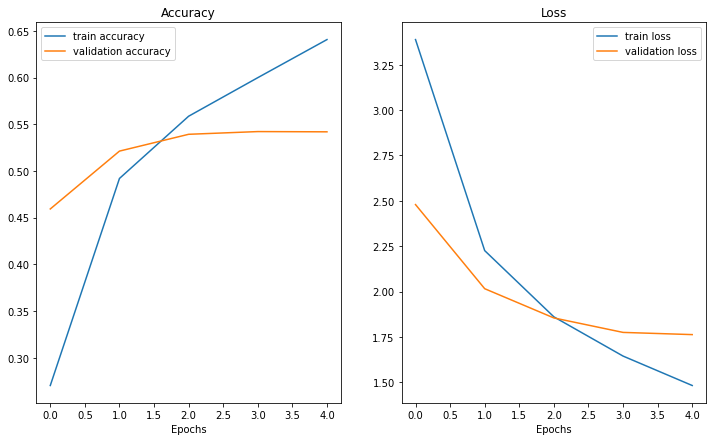

In [28]:
# loss curves
plot_loss_curves(history_featExtraction_model)

## Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen. 

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [29]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze
for layer in base_model.layers[:-5]:
  layer.trainable = False

We just made a change to the layers in our model so we need to recompile it.

Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

![](https://raw.githubusercontent.com/danchaud-vincent/tensorflow-deep-learning/main/images/06-lowering-the-learning-rate.png)

In [30]:
# Recompile the model with lower learning rate
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [31]:
# What layers in the model are trainable?
for i, layer in enumerate(model.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation_layer True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [32]:
# Check which layers are trainable in our base model?
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

Another 5 epochs should be enough to see whether any benefits come about.

We'll start the training off where the feature extraction model left off using the `initial_epoch` parameter in the `fit()` function.

In [33]:
# fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_fine_tune_5_layers_model = model.fit(train_data,
                                             epochs = fine_tune_epochs,
                                             steps_per_epoch=len(train_data),
                                             validation_data=test_data,
                                             validation_steps=int(0.15 * len(test_data)),
                                             initial_epoch=history_featExtraction_model.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 66s 240ms/step - loss: 1.2342 - accuracy: 0.6809 - val_loss: 1.6909 - val_accuracy: 0.5530
Epoch 6/10
237/237 [==============================] - 54s 225ms/step - loss: 1.1447 - accuracy: 0.6964 - val_loss: 1.6910 - val_accuracy: 0.5522
Epoch 7/10
237/237 [==============================] - 52s 217ms/step - loss: 1.0713 - accuracy: 0.7064 - val_loss: 1.6801 - val_accuracy: 0.5538
Epoch 8/10
237/237 [==============================] - 52s 217ms/step - loss: 0.9812 - accuracy: 0.7333 - val_loss: 1.7211 - val_accuracy: 0.5469
Epoch 9/10
237/237 [==============================] - 52s 219ms/step - loss: 0.9270 - accuracy: 0.7545 - val_loss: 1.6631 - val_accuracy: 0.5572
Epoch 10/10
237/237 [==============================] - 51s 211ms/step - loss: 0.8799 - accuracy: 0.7661 - val_loss: 1.6752 - val_accuracy: 0.5508


Once again, during training we were only evaluating on a small portion of the test data, let's find out how our model went on all of the test data.

In [34]:
fine_tune_5_layers_model_results = model.evaluate(test_data)
fine_tune_5_layers_model_results

790/790 [==============================] - 76s 96ms/step - loss: 1.4783 - accuracy: 0.6064


[1.4782756567001343, 0.606415867805481]

It seems like our model got a slight boost from fine-tuning

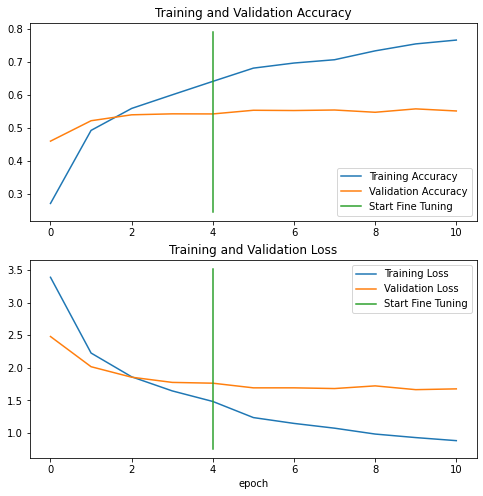

In [35]:
# Compare the historys 
compare_historys(original_history=history_featExtraction_model,
                 new_history=history_fine_tune_5_layers_model,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation not so much. Looks like our model is starting to overfit.

This is ok though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on **ImageNet** which contains many real life pictures of food just like our food dataset.

If feature extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

## Saving our trained model

To prevent having to retrain our model from scratch let's save it to file using the `save()` methode.

In [36]:
# Save our fine-tuning model
# model.save("/content/drive/MyDrive/Colab Notebooks/Zero_To_Mastery/101_food_classes_10_percent_saved_big_dog_model")

In [37]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Zero_To_Mastery/101_food_classes_10_percent_saved_big_dog_model")

To make sure our loaded model is indead a trained model, let's evaluate its performance on the test dataset.

In [38]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 76s 93ms/step - loss: 1.4977 - accuracy: 0.6021


[1.497715950012207, 0.6020594239234924]

In [39]:
# Check if the results are the same than our model results
fine_tune_5_layers_model_results

[1.4782756567001343, 0.606415867805481]

## Evaluating the performance of the big dog model across all different classes

We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.

> **Note:** Evaluating a machine learning model is as important as training one. Metrics can be deceiving. You should always visualize your model's performance on unseen data to make sure you aren't being fooled good looking training numbers.

In [40]:
import tensorflow as tf

# Download a pre-trained model from google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-10-18 18:15:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.128, 172.217.219.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   166MB/s    in 0.3s    

2022-10-18 18:15:22 (166 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [41]:
# unzip the data
saved_model_path = "/content/06_101_food_class_10_percent_saved_big_dog_model.zip"

unzip_data(saved_model_path)

In [42]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [43]:
# check to see if loaded model is a trained model
loaded_model_loss, loaded_model_acc = model.evaluate(test_data)
loaded_model_loss, loaded_model_acc

790/790 [==============================] - 72s 89ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027206659317017, 0.6077623963356018)